# Section 7. Bag of Words Text Analysis

#### Instructor: Pierre Biscaye 

This is the second of three notebooks covering the foundations for performing **text analysis** in Python. In the previous part, we learned how to perform text preprocessing. However, we didn't move beyond the text data itself. If we're interested in doing any computational analysis on the text data, we still need approaches to convert the text into a **numeric representation**.

In Part 2 of this series, we'll explore one of the most straightforward ways to generate a numeric representation from text: the **bag-of-words** (BoW). We will implement the BoW representation to transform the airline tweets data into numerical representation, and then build a classifier to explore what we can learn about the sentiment of the tweets. At the heart of the bag-of-words approach lies the assumption that the frequency of specific tokens is informative about the semantics and sentiment underlying the text. We'll make heavy use of the `scikit-learn` package to do so, as it provides a nice framework for constructing the numeric representations.

The content of this notebook draws from UC Berkeley D-Lab's Python Text Analysis [course](https://github.com/dlab-berkeley/Python-Text-Analysis).
    
### Sections
1. Exploratory Data Analysis and Preprocessing
2. The Bag-of-Words Representation: Learn how to convert text data into a numerical representation through a Bag-of-Words approach.
3. Term Frequency-Inverse Document Frequency: Understand the TF-IDF algorithm and how it complements the Bag-of-Words representation. 
4. Sentiment Classification: Use the numerical representations of text data to perform sentiment analysis.

### Required packages
* pandas
* numpy
* re
* matplotlib
* seaborn
* string
* scikit-learn
* nltk
* spacy
* transformers

### Required data
* airline_tweets.csv

In [1]:
# Import packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline

# 1. Exploratory data analysis and preprocessing

Before we do any preprocessing or modeling, we always should do some exploratory data analysis to get a feel for the dataset.

First, let's take a look again at the first few rows of the dataset.

In [2]:
# Load dataset in
tweets_path = 'Data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As a refresher, each row in this dataframe correponds to a tweet. The following columns are of main interests to us. 
- `text` (`str`): the text of the tweet.
- `airline_sentiment` (`str`): the sentiment of the tweet, labeled as "neutral", "positive", or "negative". 
- `airline` (`str`): the airline that is tweeted about.
- `retweet count` (`int`): how many times the tweet was retweeted.

There are other columns containing metadata of the tweet, such as the author of the tweet, when it was created, the timezone of the user, and others, which we will set aside for now. 

To prepare us for sentiment classification, we'll partition the dataset so as to focus on the "positive" and "negative" tweets for now. 

In [4]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)
tweets.shape

(11541, 15)

Let's take a look at the text of a few of these tweets.

In [5]:
# Print first five tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


We can already see that some of these tweets contain negative sentiment—how can we tell this is the case? 

Next, let's take a look at the distribution of sentiment labels in this dataset. 

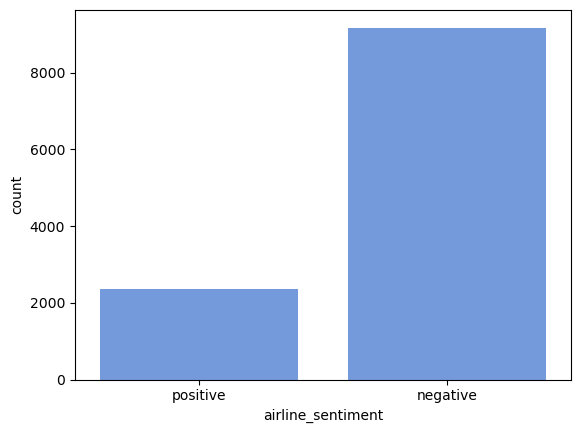

In [6]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

It looks like the majority of the tweets we have in this dataset have been classified as expressing negative sentiment.

Let's take a look at what gets more retweeted:

In [7]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

Negative tweets are clearly retweeted more often than tweets having positive sentiments.

Let's see which airline receives most negative tweets:

In [8]:
# Get the proportion of negative tweets by airline
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


It looks like people are most dissatified with US Airways, followed by American Airlines, both having over 85\% negative tweets!

That's enough data exploration for now. 

## Preprocessing

Before conducting our own sentiment analysis, we need to preprocess the text data so that they are in a standard format.

We spent much of the last workshop learning how to preprocess data. Let's apply what we learned! 

Looking at some of the tweets above, we can see that while they are in pretty good shape, we can do some additional processing on them. In our pipeline, we'll omit the tokenization process, since we will perform it in a later step. 

Let's put together a text cleaning pipeline. 

We'll accomplish this by writing a function called `preprocess()` that performs the following steps on a text input:
* Step 1: Lowercase text.
* Step 2: Replace the following patterns with placeholders:
    * URLs &rarr; ` URL `
    * Digits &rarr; ` DIGIT `
    * Hashtags &rarr; ` HASHTAG `
    * Tweet handles &rarr; ` USER `
* Step 3: Remove extra blankspaces.

**Question**: Why might some of these steps make sense for a sentiment analysis task? What step(s) might we reconsider?

In [11]:
blankspace_pattern = r'\s+'
url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
handle_pattern = r'@\w+'
digit_pattern = r'\d+'
hashtag_pattern = r'[＃#]' # what is different about this one?

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''

    # Step 1: Lowercase
    text = text.lower()

    # Step 2: Replace patterns with placeholders
    text = re.sub(url_pattern, ' URL ', text)
    text = re.sub(handle_pattern, ' HANDLE ', text)
    text = re.sub(digit_pattern, ' DIGITS ', text)
    text = re.sub(hashtag_pattern, ' ', text)

    # Step 3: Remove extra whitespace characters
    text = re.sub(blankspace_pattern, ' ', text)
    text = text.strip()
    
    return text

Let's test the `preprocess()` function on an example tweet to see how it's working. Then we can apply it to the entire `text` column in the tweets DataFrame.

In [12]:
example_tweet = 'congrats @Beyonce #Finally and @kendricklamar #NotLikeUs for big wins at the 2025 #Grammys https://abcnews.go.com/GMA/Culture/2025-grammys-winners-list/story?id=118247847'

# Print the example tweet
print(example_tweet)
print(f"{'='*50}")

# Print the preprocessed tweet
print(preprocess(example_tweet))

congrats @Beyonce #Finally and @kendricklamar #NotLikeUs for big wins at the 2025 #Grammys https://abcnews.go.com/GMA/Culture/2025-grammys-winners-list/story?id=118247847
congrats HANDLE finally and HANDLE notlikeus for big wins at the DIGITS grammys URL


In [13]:
# Apply the function to text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    HANDLE plus you've added commercials to the ex...
1    HANDLE it's really aggressive to blast obnoxio...
2      HANDLE and it's a really big bad thing about it
3    HANDLE seriously would pay $ DIGITS a flight f...
4    HANDLE yes, nearly every time i fly vx this “e...
Name: text_processed, dtype: object

Congratulations! Preprocessing is complete. Let's dive into the bag-of-words!

# 2. The Bag-of-Words representation

The idea of bag-of-words (BoW), as the name suggests, is quite intuitive: we take a text (or all its words) and toss it in a bag. The action of "throwing" the document in a bag disregards relative position between words, so what is "in the bag" is essentially an unsorted set of words [(Jurafsky & Martin, 2024, p.62)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). We then sort these into a list of unique words and the frequency with which they appear. 

For example, as shown in the following illustration, the word "coffee" appears twice. 

<img src='Images/bow-illustration-1.png' alt="BoW-Part2" width="600">

Analysis based on a bag-of-words representation primarily focuses on word frequency while discarding considerations around word order. 

In the context of sentiment analysis, the sentiment of a tweet is conveyed more strongly by specific words. For example, if a tweet contains the word "happy", it likely conveys positive sentiment, but not always (e.g., "not happy" denotes the opposite sentiment). When these words come up more often, they probably more strongly convey the sentiment. Clearly, a bag-of-words approach can help with sentiment analysis, but it has serious limitations.

## Document Term Matrix

Now let's implement the idea of bag-of-words. Before we go deep into that, let's step back for a moment. In practice, text analysis often involves handling many documents. From now on, we use the term **document** to indicate a piece of text that we perform analysis on. It could be a news article, a book chapter, a phrase, a sentence, a tweet, etc.. As long as it can be represented by a string of text, the length dosen't really matter. 

Imagine we have four documents (i.e., the four coffee-related phrases shown above) and toss them all in the bag. Instead of a word-frequency list, we can create a **document-term matrix** (DTM), which preserves information about each document rather than simply aggregating across all documents. In a DTM, the word list is the **vocabulary** (V) that holds all unique words occurring across the documents. For each **document** (D), we count the number of occurences of each word in the vocabulary, and then plug the number into the matrix. In other words, the DTM we construct is a $D \times V$ matrix, where each row corresponds to a document, and each column corresponds to a token (or "term").

In the following example, the unique tokens (in this case individual words) in this set of documents, in alphabetical order, are in columns. For each document, we mark the occurence of each word showing up in the document. The numerical representation for each document is a row in the matrix. For example, "the coffee roaster" or the first document has numerical representation $[0, 1, 0, 0, 0, 1, 1, 0]$.

Note that the left index column now displays these documents as texts, but typically we would just assign an index to each of them. 

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

To create a DTM, we will use `CountVectorizer` from the package `sklearn`.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

The image below summarizes the general workflow of `CountVectorizer`:

<img src='Images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Let's walk through these steps with the example of coffee phrases shown above.

### A Toy Example

In [15]:
# A toy example containing four documents (phrases)
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

The first step is to initialize a `CountVectorizer` object. Within the round paratheses are the parameter settings we may choose to specify. You can take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and see what options are available.  

For now we can just leave it blank for the default settings. 

In [16]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

The second step is to `fit` this `CountVectorizer` object to the data, which means creating a vocabulary of tokens from the set of documents. Thirdly, we `transform` our data according to the "fitted" `CountVectorizer` object, which means taking each of the documents and transforming it into a DTM according to the vocabulary established by the "fitting" step.

It may sound a bit complex but steps 2 and 3 can actually be done in one swoop using a `fit_transform` function.

In [17]:
# Fit and transform to create DTM
test_count = vectorizer.fit_transform(test)

Let's take a look at the resulting DTM. 

In [18]:
test_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (4, 8)>

Apparently the return is a "sparse matrix"—a matrix that contains a lot zeros. It actually makes sense. For each document we definitely have words that don't occur at all, which are counted zero in the DTM. This sparse matrix is stored in a "Compressed Sparse Row" format, which is a memory-saving format that is designed to deal with sparse matrices. 

Let's convert it to a dense matrix, where those zeros are organized as in a numpy array.

In [19]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

So this is our DTM. It is the same as shown above, but to make it more reader-friendly, let's convert it to a dataframe. The column names should be tokens in the vocabulary, which we can access with `get_feature_names_out()`.

In [20]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [21]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Here it is! The DTM of our toy data is now a dataframe. The index of `test_dtm` corresponds to the position of each document in the `test` list. 

Now let's apply this process to the preprocessed tweet data we set up above.

### DTM for Tweets

We'll still begin with initializing a `CountVectorizer` object. In the following cell, we have included a few parameters that people often adjust. These parameters are currently set to their default values.

As shown below, when we construct a DTM, the default is to lowercase the input text. If nothing is provided for `stop_words`, the default is to keep them. The next three parameters are used to control the size of the vocabulary, which we'll return to in a minute.

In [22]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [23]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 191776 stored elements and shape (11541, 9817)>

In [24]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [25]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
print(first_dtm.shape)

(11541, 9817)


If we leave the `CountVectorizer` to the default setting, in total we have a vocabulary size of 9817. 

In [26]:
first_dtm.head()

,_exact_,aa,aaaand,aaadvantage,aadelay,aadv,aadvantage,aafail,aal,aaron,...,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most of the tokens have zero occurences at least in the first five tweets. This is not surprising when most tweets have relatively few words and we are indexing over nearly 10,000 vocabulary terms. 

Let's take a closer look at the DTM.

In [27]:
# Most frequent tokens
first_dtm.sum().sort_values(ascending=False).head(10)

handle    12925
to         6987
digits     6805
the        5088
you        3635
for        3386
flight     3341
and        3276
on         3142
my         2751
dtype: int64

It is not surprising to see "handle" and "digit" to be among the most frequent tokens as we replaced each idiosyncratic one to these placeholders. The rest of the most frequent list are mostly stop words, except for "flight".

Perhaps a more interesting pattern is to look for which token appears most in any given tweet:

In [29]:
counts = pd.DataFrame()

# Retrieve the index to the tweet where each token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurence 
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
counts[(counts['token'] != 'digits')
         & (counts['token'] != 'handle')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
8148,the,5
7750,to,5
11007,to,5
557,to,5
5005,to,5
10572,to,5
10923,the,5
5513,to,5


It looks like among all tweets, at most a token appears 6 times, and it is either the word "It" or the word "worst". 

Let's go back to our tweets dataframe and get the 918th tweet.

In [30]:
# Look at index 918: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

In [31]:
tweets.iloc[918]

tweet_id                                                       569882164382322688
airline_sentiment                                                        negative
airline_sentiment_confidence                                                  1.0
negativereason                                             Customer Service Issue
negativereason_confidence                                                     1.0
airline                                                                    United
airline_sentiment_gold                                                        NaN
name                                                                   jacob_bach
negativereason_gold                                                           NaN
retweet_count                                                                   0
text                            @united is the worst. Worst reservation polici...
tweet_coord                                                                   NaN
tweet_created   

## Customizing the `CountVectorizer`

So far we used to the default parameter settings to create our DTMs, but in many cases we may want to customize the `CountVectorizer` object. The purpose of doing so is to further filter out unnecessary tokens. In the example below, we tweak the following parameters:

- `stop_words = 'english'`: exclude English stop words 
- `min_df = 2`: exclude words that don't occur at least twice across all documents
- `max_df = 0.95`: exclude words if they occur in more than 95\% of the documents 

**Question**: Does it seem reasonable to set these parameters? Keep in mind the objective of this text analysis task: sentiment analysis.

Typically we are not interested in words whose frequencies are either too low or too high, so we use the `min_df` and `max_df` parameters to trim them out. Alternatively, we can also define our vocabulary size to be $N$ using the `max_feature` parameter—this tells `CountVectorizer` to only consider the top $N$ most frequent tokens when construct the DTM.

In [32]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [33]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

In [34]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 9817)
(11541, 4679)


Our second DTM has a substantially smaller vocabulary, compared to the first one.

In [35]:
second_dtm.sum().sort_values(ascending=False).head(10)

digits       6805
flight       3341
cancelled     964
thanks        926
service       912
just          801
customer      728
help          703
time          696
url           685
dtype: int64

The most frequent token list now includes words that make more sense to us, for example, "cancelled", "service", etc. Note that it no longer includes "handle," as this was likely included in every tweet.

## Lemmatize the Text Input

Recall from notebook 7a that we introduced how `spaCy` can perform **lemmatization**, i.e., removing morphological affixes on words. With lemmatization, we keep only word stems in texts, which presumably should capture the core meaning of the text. 

Now let's implement lemmatization on our tweet data, and pass the lemmatized text to create a third DTM. We'll write a function `lemmatize_text`. It requires a text input, and the output is the same text except all tokens are lemmatized. We will use the `nlp()` pipeline for this, as lemmatization is one of the linguistic annotations that the `nlp` pipeline automatically does. We can use `token.lemma_` to access the annotation.

In [36]:
# Import spaCy (can take a few seconds)
import spacy
nlp = spacy.load('en_core_web_sm')

In [37]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemma = []

    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma

Let's apply the function to an example tweet first.

In [38]:
# Apply the function to an example tweet
print(tweets.iloc[101]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[101]['text_processed']))

. HANDLE does that mean you don't have a policy for destroyed luggage?
. handle do that mean you do not have a policy for destroy luggage ?


Now let's lemmatize the tweet data, and save the output to a new column `text_lemmatized`.

In [39]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

In [40]:
# Let's save this dataset with the cleaned tweets for future use
tweets.to_csv("Data/tweets_clean.csv", index=False)

In [41]:
tweets = pd.read_csv("Data/tweets_clean.csv", sep=',')

Now with the `text_lemmatized` column, let's create a third DTM. The parameter settings are the same as the second DTM. 

In [42]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aafail,aal,abandon,abc,ability,able,aboard,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 9817)
(11541, 4679)
(11541, 3759)


Let's print the top 10 most frequent tokens as usual. These tokens are now word stems, and the counts also change after lemmatization. 

In [44]:
# Get the most frequent tokens in the third DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digits      6725
flight      4066
thank       1456
hour        1135
delay        950
cancel       945
service      940
customer     906
time         858
just         801
dtype: int64

In [45]:
# Compared to the most frequent tokens in the second DTM
second_dtm.sum().sort_values(ascending=False).head(10)

digits       6805
flight       3341
cancelled     964
thanks        926
service       912
just          801
customer      728
help          703
time          696
url           685
dtype: int64

# 3. Term Frequency-Inverse Document Frequency 

So far, we've been relying on word frequencies to give us information about a document. This assumes that if a word appears more often in a document, it's more informative. However, this may not always be the case. For example, we've already removed stop words because they are not informative, despite the fact that they appear many times in a document. We also know the word "flight" is among the most frequent words, but it is also not that informative, because it appears in many documents. Since we're looking at airline tweets, we shouldn't be surprised to see the word "flight"!

To remedy this, we use a weighting scheme called **tf-idf (term frequency-inverse document frequency)**. The big idea behind tf-idf is to weight a word not just by its frequency within a document, but also by its frequency across documents. The idea is that words are more informative if there is variation in their appearance across documents, and when they appear frequently within a given document. So, when we construct the DTM, we will be assigning each term a **tf-idf score**. Specifically, term $t$ in document $d$ is assigned a tf-idf score as follows:

<img src='Images/tf-idf.png' alt="TF-IDF" width="1200">

In essence, the tf-idf score of a word in a document is the product of two components: term frequency (tf) and inverse document frequency (idf). The idf acts as a scaling factor. If a word occurs in all documents, then idf equals to 1 and no scaling will happen. But idf is typically greater than 1, which is the weight we assign to the word to make the tf-idf score higher, so as to highlight that the word is informative. In practice, we add 1 to both the denominator and nominator ("add-1 smooth"), to prevent any issues with zero occurrences.

We will create a tf-idf DTM using `sklearn`'s `TfidfVectorizer` function. It takes mainly the same parameters as `CountVectorizer`.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [48]:
# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 87606 stored elements and shape (11541, 3759)>

In [49]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aafail,aal,abandon,abc,ability,able,aboard,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You may have noticed that we still have the same vocabulary size as above. This is because we used the same parameter settings when creating the vectorizer. But the values in the matrix are different now—they are tf-idf scores instead of raw counts. 

## Interpret TF-IDF Values

Let's take a look at the documents where each term has the highest tf-idf value.

We'll use `idxmax()` to find the index to these documents.

In [50]:
# Retrieve the index to the document
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aafail         9872
aal           10630
              ...  
yyz            1350
zero           5219
zone           3177
zoom           3920
zurich        10622
Length: 3759, dtype: int64

For example, the term "worst" occurs distinctively in the 918th tweet. 

In [51]:
tfidf.idxmax()['worst']

918

Recall from previous part that it is the tweet where the word "worst" appears 6 times!

In [52]:
tweets['text'].iloc[918]

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

How about "delay"? 

In [53]:
tfidf.idxmax()['delay']

5740

In [54]:
tweets['text_processed'].iloc[5740]

"HANDLE what's the delay if the system isn't down?"

It seems there is no instance where 'delay' appears more than once.

In the practice notebook, you will be asked to use the tf-idf dataframe to plot the 10 most informative words in tweets that have been classified as positive and negative.

# 4. Introduction to Sentiment Classification

Now that we have a numerical representation of the text, we are ready operate on it for our sentiment classification task. We'll construct a DTM from the text data, and use that to predict the sentiment labels using a logistic regression model, as covered in Section 6 of this course. 

We will split the tweets data into traning and test samples, then train the model on the training sample. The target is the airline sentiment being positive or negative. The list of features we'll pass to the model is exactly the vocabulary of the DTM. The coefficients from the model will tell us whether a feature contributes positively or negatively to the predicted value. The predicted value will then inform the predicted label, either positive (when $p>=0.5$) or negative (when $p<0.5$). 

We will then evaluate the performance of the model on the test data. 

Now that we have the tf-idf dataframe, the feature set is ready. Let's dive into model specification!

In [55]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

We'll use the `train_test_split` function from `sklearn` to separate our data into two sets:

In [56]:
# Train-test split
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Now let's specify and fit a logistic regression model.

Recall that the positive and negative classes are not balanced, so we can tell the classifier to automatically assign weights (through the `class_weight` parameter) proportional to our data in order to have it pay more attention to the minority class.

In [57]:
# Specify the model
lr = LogisticRegressionCV(Cs=10, # how many different values of the inverse regularization strength (C) should be tested, 10 is default
                                 cv=5, # 5-fold cross-validation
                                 solver='liblinear', # suitable for smaller datasets, supports lasso and ridge regularization
                                 class_weight='balanced', # automatically adjusts weights to handle imbalanced datasets
                                 random_state=5, # for reproducibility
                                 refit=True) # retrains full dataset on the best C value
# Fit the logistic regression model
model = lr.fit(X_train, y_train)

/Users/pierrebiscaye/miniforge3/envs/ucads_ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
/Users/pierrebiscaye/miniforge3/envs/ucads_ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnin

How does it perform?

In [58]:
# Get the training and test accuracy
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9465987868284229
Test accuracy: 0.9125162407968818


The model got ~95% accuracy on the training set, and ~91% on the test set - that's pretty good! The similarity between the two performances is also a good sign—it means we were able to generalize pretty well.

Let's also take a look at the fitted coefficients to see if what we modeled makes sense! 

We can access them using `coef_`, and we can match each coefficient to the tokens from the vectorizer:

In [59]:
# Get coefs of all features
coefs = model.coef_.ravel()

# Get all tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

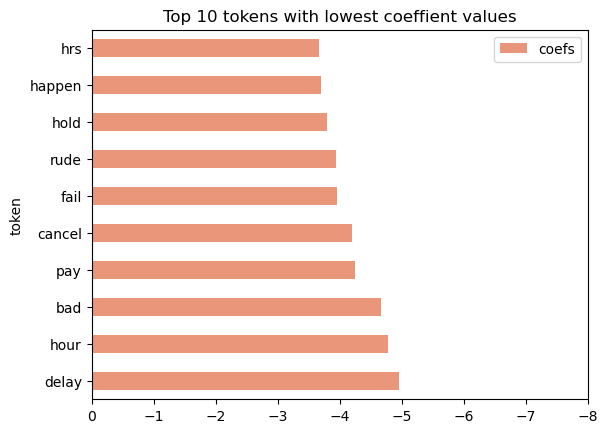

In [61]:
# Plot the top 10 tokens that have the lowest coefs
neg_coef = importance.sort_values('coefs').head(10)
neg_coef.plot(kind='barh', 
              xlim=(0, -8),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

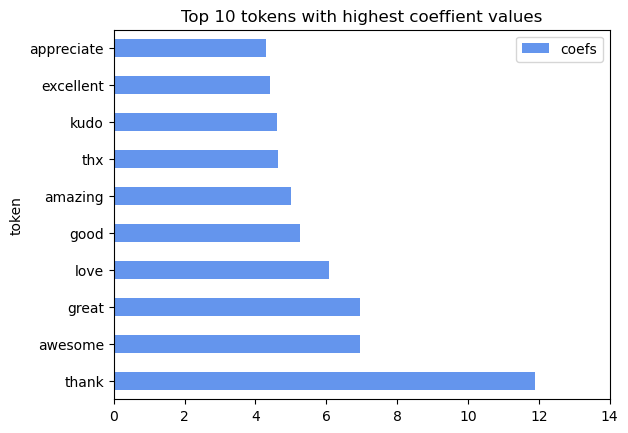

In [62]:
# Plot the top 10 tokens that have the highest coefs
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef.sort_values('coefs', ascending=False).plot(kind='barh', 
                                                    xlim=(0, 14),
                                                    x='token',
                                                    color='cornflowerblue',
                                                    title='Top 10 tokens with highest coeffient values');

**Question:** Do these make sense? Could an analysis based on a set of such keywords have been used for the sentiment classification in the tweets dataset we are using? What would a modeler need to predict sentiment based on tweet text without preexisting classification as positive or negative?


## Key Points

* A Bag-of-Words representation is a simple method to transform our text data to numbers. It focuses on word frequency but not word order. 
* A TF-IDF representation is a step further; it also considers if a certain word distinctively appears in one document or occurs uniformally across all documents. 
* With a numerical representation, we can perform a range of text classification tasks, such as sentiment analysis. 

